## Set up

In [1]:
%cd "t:\My Drive\wdir\s14-online_store"
%cd "drive/MyDrive/wdir/s14-online_store/"

import pandas as pd
from plotly import graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
import warnings

%pwd

t:\My Drive\wdir\s14-online_store
[WinError 3] The system cannot find the path specified: 'drive/MyDrive/wdir/s14-online_store/'
t:\My Drive\wdir\s14-online_store


't:\\My Drive\\wdir\\s14-online_store'

In [ ]:
%%bash
ls -l datasets/

total 0
drwxrwxrwx 0 e9k e9k 512 Jul 31 17:05 clean
drwxrwxrwx 0 e9k e9k 512 Jul 31 17:02 raw
drwxrwxrwx 0 e9k e9k 512 Jul 31 17:06 results


: 

In [ ]:
# Cargar los archivos de datos
mark_events = pd.read_parquet('datasets/clean/mark_events_ue.parquet')
users = pd.read_parquet('datasets/clean/users.parquet')
ab_events = pd.read_parquet('datasets/clean/ab_events.parquet')
participants = pd.read_parquet('datasets/clean/participants.parquet')

: 

# Exploratory Data Analysis (EDA)

Tasa de conversión (vista de producto): 179.12%
Tasa de conversión (agregar al carrito): 86.55%
Tasa de conversión (compra): 84.04%


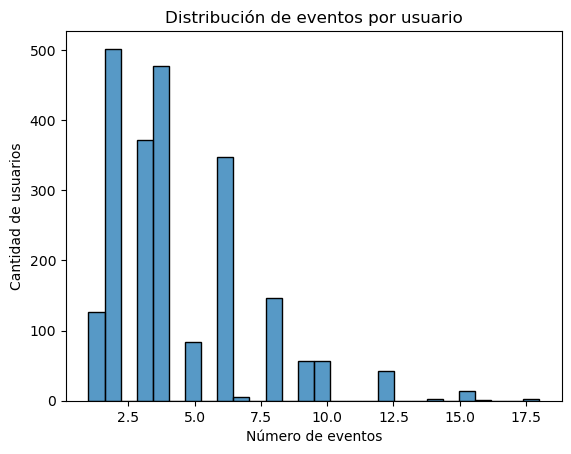

: 

In [ ]:
# Análisis de las tasas de conversión en cada etapa del embudo
total_users = participants.shape[0]
product_page_views = ab_events[ab_events['event_name'] == 'product_page'].shape[0]
product_cart_additions = ab_events[ab_events['event_name'] == 'product_cart'].shape[0]
purchases = ab_events[ab_events['event_name'] == 'purchase'].shape[0]

conversion_rate_page = product_page_views / total_users
conversion_rate_cart = product_cart_additions / total_users
conversion_rate_purchase = purchases / total_users

print(f"Tasa de conversión (vista de producto): {conversion_rate_page:.2%}")
print(f"Tasa de conversión (agregar al carrito): {conversion_rate_cart:.2%}")
print(f"Tasa de conversión (compra): {conversion_rate_purchase:.2%}")

# Distribución de eventos por usuario
events_per_user = ab_events['user_id'].value_counts()
sns.histplot(events_per_user, kde=False)
plt.title('Distribución de eventos por usuario')
plt.xlabel('Número de eventos')
plt.ylabel('Cantidad de usuarios')
plt.show()

Usuarios en ambos grupos: 0


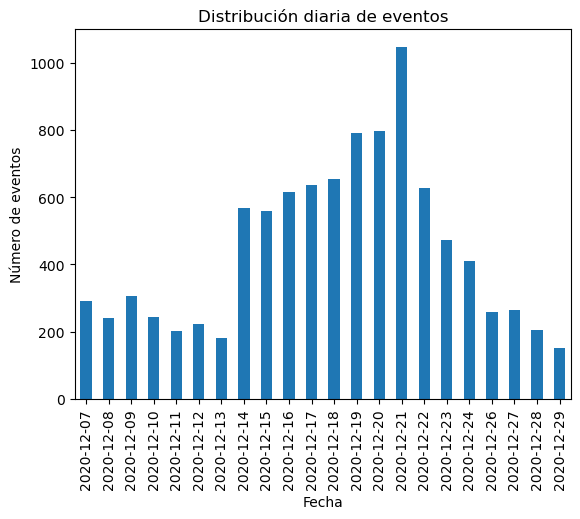

: 

In [ ]:
# Verificar usuarios en ambos grupos
overlap_users = participants[participants.duplicated('user_id', keep=False)]
print(f"Usuarios en ambos grupos: {overlap_users.shape[0]}")

# Distribución de eventos por día
ab_events['event_date'] = ab_events['event_dt'].dt.date
daily_events = ab_events.groupby('event_date').size()
daily_events.plot(kind='bar')
plt.title('Distribución diaria de eventos')
plt.xlabel('Fecha')
plt.ylabel('Número de eventos')
plt.show()

In [ ]:
# Ignore the specific warning
warnings.filterwarnings('ignore', category=UserWarning, message='Boolean Series key will be reindexed to match DataFrame index.')

# Evaluación de la prueba A/B
def z_test(event_name):
    control_events = ab_events[(ab_events['event_name'] == event_name) & (participants['group'] == 'A')].shape[0]
    test_events = ab_events[(ab_events['event_name'] == event_name) & (participants['group'] == 'B')].shape[0]
    control_size = participants[participants['group'] == 'A'].shape[0]
    test_size = participants[participants['group'] == 'B'].shape[0]
    z_stat, p_val = proportions_ztest([test_events, control_events], [test_size, control_size])
    return z_stat, p_val

# Z-test para vistas de página de producto
z_stat_page, p_val_page = z_test('product_page')
print(f"Z-estadístico (vistas de producto): {z_stat_page:.2f}, P-valor: {p_val_page:.4f}")

# Z-test para adiciones al carrito de producto
z_stat_cart, p_val_cart = z_test('product_card')
print(f"Z-estadístico (agregar al carrito): {z_stat_cart:.2f}, P-valor: {p_val_cart:.4f}")

# Z-test para compras
z_stat_purchase, p_val_purchase = z_test('purchase')
print(f"Z-estadístico (compra): {z_stat_purchase:.2f}, P-valor: {p_val_purchase:.4f}")

# Resumen y conclusiones
print(f"Tasa de conversión (vista de producto): {conversion_rate_page:.2%}")
print(f"Tasa de conversión (agregar al carrito): {conversion_rate_cart:.2%}")
print(f"Tasa de conversión (compra): {conversion_rate_purchase:.2%}")

Z-estadístico (vistas de producto): nan, P-valor: nan
Z-estadístico (agregar al carrito): nan, P-valor: nan
Z-estadístico (compra): 1.07, P-valor: 0.2857
Tasa de conversión (vista de producto): 179.12%
Tasa de conversión (agregar al carrito): 86.55%
Tasa de conversión (compra): 84.04%


c:\Users\Guill\miniconda3\envs\ab_test\lib\site-packages\statsmodels\stats\weightstats.py:792: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std
c:\Users\Guill\miniconda3\envs\ab_test\lib\site-packages\statsmodels\stats\weightstats.py:792: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std


: 

In [ ]:
# Plot a funnel with plotly
stages = ["Vistas de producto", "Agregar al carrito", "Compras"]
values = [product_page_views, product_cart_additions, purchases]

fig = go.Figure(go.Funnel(
    y = stages,
    x = values,
    textinfo = "value+percent initial"))

fig.show()


: 

In [ ]:
from IPython.display import display, Markdown


# Interpretación de resultados de las pruebas Z
def show_result(txt, bool_):
    base = f"Diferencia estadísticamente significativa en **{txt}** entre los grupos de control y prueba."
    if not bool_:
        base = f"No se puede rechazar la hipótesis nula: **{txt}**"
    display(Markdown(base.capitalize()))

if p_val_page < 0.05:
    show_result("vistas de producto")
else:
    show_result("vistas de producto", False)


if p_val_cart < 0.05:
    show_result("adiciones al carrito")
else:
    show_result("adiciones al carrito", False)

if p_val_purchase < 0.05:
    show_result("adiciones al carrito")
else:
    show_result("adiciones al carrito", False)

No se puede rechazar la hipótesis nula: **vistas de producto**

No se puede rechazar la hipótesis nula: **adiciones al carrito**

No se puede rechazar la hipótesis nula: **adiciones al carrito**

: 

: 